In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
pd.options.display.max_rows = 999
import gc
import numpy as np
import cudf
from glob import glob
from tqdm import tqdm

def load_jsonl(load_path, max_load_chunk=100000):
    chunks = pd.read_json(load_path, lines=True, chunksize=max_load_chunk)
    
    dfs = []
    for e, chunk in tqdm(enumerate(chunks)):
        if e > max_load_chunk:
            break
        event_dict = {"session": [], "aid": [], "ts": [], "type": []}
        for session, events in zip(chunk["session"].tolist(), chunk["events"].tolist()):
            for event in events:
                event_dict["session"].append(session)
                event_dict["aid"].append(event["aid"])
                event_dict["ts"].append(event["ts"])
                event_dict["type"].append(event["type"])
        dfs.append(pd.DataFrame(event_dict))

    return pd.concat(dfs).reset_index(drop=True).astype({"ts": "datetime64[ms]"})

In [2]:
train = load_jsonl("../input/otto-recommender-system/train.jsonl")
train.shape

129it [24:44, 11.51s/it]


(216716096, 4)

In [3]:
test = load_jsonl("../input/otto-recommender-system/test.jsonl")
test.shape

17it [01:06,  3.91s/it]


(6928123, 4)

In [4]:
train.head()

,session,aid,ts,type
0,0,1517085,2022-07-31 22:00:00.025,clicks
1,0,1563459,2022-07-31 22:01:44.511,clicks
2,0,1309446,2022-08-01 15:23:59.426,clicks
3,0,16246,2022-08-01 15:28:39.997,clicks
4,0,1781822,2022-08-01 15:31:11.344,clicks


In [5]:
test.head()

,session,aid,ts,type
0,12899779,59625,2022-08-28 22:00:00.278,clicks
1,12899780,1142000,2022-08-28 22:00:00.378,clicks
2,12899780,582732,2022-08-28 22:00:58.352,clicks
3,12899780,973453,2022-08-28 22:01:49.199,clicks
4,12899780,736515,2022-08-28 22:02:16.868,clicks


In [6]:
train['type'].value_counts()

clicks    194720954
carts      16896191
orders      5098951
Name: type, dtype: int64

In [7]:
train['type'] = train['type'].map({'clicks':0, 'carts':1, 'orders':2}).astype('int8')
test['type'] = test['type'].map({'clicks':0, 'carts':1, 'orders':2}).astype('int8')

In [8]:
train.session = train.session.astype('int32')
test.session = test.session.astype('int32')
train.aid = train.aid.astype('int32')
test.aid = test.aid.astype('int32')
train.dtypes

session             int32
aid                 int32
ts         datetime64[ns]
type                 int8
dtype: object

In [9]:
train.head()

,session,aid,ts,type
0,0,1517085,2022-07-31 22:00:00.025,0
1,0,1563459,2022-07-31 22:01:44.511,0
2,0,1309446,2022-08-01 15:23:59.426,0
3,0,16246,2022-08-01 15:28:39.997,0
4,0,1781822,2022-08-01 15:31:11.344,0


In [10]:
test.head()

,session,aid,ts,type
0,12899779,59625,2022-08-28 22:00:00.278,0
1,12899780,1142000,2022-08-28 22:00:00.378,0
2,12899780,582732,2022-08-28 22:00:58.352,0
3,12899780,973453,2022-08-28 22:01:49.199,0
4,12899780,736515,2022-08-28 22:02:16.868,0


In [1]:
train.to_parquet('../input/train.parquet')
test.to_parquet('../input/test.parquet')
!ls -l ../input/t*.parquet

-rw-r--r-- 1 99 99   79598546 Dec  7 19:24 ../input/test.parquet
-rw-r--r-- 1 99 99 2312182606 Dec  7 19:24 ../input/train.parquet


In [2]:
!rm -r fold
!rm -r fold_val
!rm -r oof
!rm -r weights
!rm -r trainset
!rm -r model-weights
!rm -r candidates

!mkdir fold
!mkdir oof
!mkdir weights

rm: cannot remove 'fold': No such file or directory
rm: cannot remove 'fold_val': No such file or directory
rm: cannot remove 'oof': No such file or directory
rm: cannot remove 'weights': No such file or directory
rm: cannot remove 'trainset': No such file or directory
rm: cannot remove 'model-weights': No such file or directory
rm: cannot remove 'candidates': No such file or directory


In [3]:
!nvidia-smi

Mon Jan 23 22:30:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    45W / 163W |    611MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

# Starting Full dataset processing / Writting by batchs

In [4]:
import gc
import cudf

def freemem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        if df[col].dtype == 'Int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'Float64':
            df[col] = df[col].astype('float32')
    gc.collect()
    return

maptype = {'clicks':0, 'carts':1, 'orders':2}

In [6]:
# train = cudf.read_parquet('../input/train.parquet')
# train['ts'] = train['ts'].astype('int64') // 1000000
# freemem(train)
# gc.collect()
# for n, s in enumerate(range(0, train.shape[0], 2000000)):
#     e = s+2000000
#     if e > train.shape[0]: e = train.shape[0]
#     tmp2 = train.iloc[s:e].copy().reset_index(drop=True)
#     if tmp2.shape[0]>0:
#         tmp2.to_parquet(f'fold/train-split{n}.parquet')
#     del tmp2
# gc.collect()

# train.shape

In [7]:
# test = cudf.read_parquet('../input/test.parquet')
# test['ts'] = test['ts'].astype('int64') // 1000000
# freemem(test)
# for n, s in enumerate(range(0, test.shape[0], 1750000)):
#     e = s+1750000
#     if e > test.shape[0]: e = test.shape[0]
#     tmp2 = test.iloc[s:e].copy().reset_index(drop=True)
#     if tmp2.shape[0]>0:
#         tmp2.to_parquet(f'fold/test-split{n}.parquet')
#     del tmp2
# gc.collect()

# test.shape

In [8]:
# train.head()

In [9]:
# from glob import glob
# files = list( 
#     glob('../input/otto-validation/train_parquet/*') + 
#     glob('../input/otto-validation/test_parquet/*')
# )
# files[0]

In [10]:
# !mkdir fold_val

# for fn in glob('../input/otto-validation/train_parquet/*'):
#     train = pd.read_parquet(fn)
#     train['ts'] = (train['ts']//1000).astype('int32')
#     train['type'] = train['type'].map({'clicks':0 ,'carts':1 ,'orders':2 ,}).astype('int8')
#     freemem(train)
#     gc.collect()
#     fn = fn.split('/')[-1]
#     print(train.shape, fn)
#     train.to_parquet(f'fold_val/train_{fn}')

# for fn in glob('../input/otto-validation/test_parquet/*'):
#     train = pd.read_parquet(fn)
#     train['ts'] = (train['ts']//1000).astype('int32')
#     train['type'] = train['type'].map({'clicks':0 ,'carts':1 ,'orders':2 ,}).astype('int8')
#     freemem(train)
#     gc.collect()
#     fn = fn.split('/')[-1]
#     print(train.shape, fn)
#     train.to_parquet(f'fold_val/valid_{fn}')

In [5]:
# files = list( 
#     glob('fold/train*') + 
#     glob('fold/valid*') + 
#     glob('fold/test*')
# )
# print(len(files))

# train = pd.read_parquet(files)
# train = cudf.from_pandas(train)

train = cudf.read_parquet('../input/train.parquet')
train['ts'] = train['ts'].astype('int64') // 1000000
freemem(train)

train['day'] = (train['ts'] - train['ts'].min()) / (24*60*60)
dt0 = train.groupby('session')[['aid','day']].agg({'aid':'count', 'day':'max'}).reset_index().sort_values('session').reset_index(drop=True)
train.shape

(216716096, 5)

In [6]:
label = cudf.read_parquet('../input/otto-validation/test_labels.parquet')
dt0.columns = ['session', 'len', 'day']
label = label.merge(dt0, on='session', how='left')
label = label.sort_values(['session']).reset_index(drop=True)
label

,session,type,ground_truth,len,day
0,11098528,clicks,[1679529],27,27.813773
1,11098528,carts,[1199737],27,27.813773
2,11098528,orders,"[990658, 950341, 1462506, 1561739, 907564, 369...",27,27.813773
3,11098529,clicks,[1105029],3,22.916921
4,11098530,orders,[409236],7,21.018831
...,...,...,...,...,...
2212687,12899774,clicks,[1399483],2,27.999722
2212688,12899775,clicks,[1760714],2,27.999884
2212689,12899776,clicks,[1737908],2,27.999850
2212690,12899777,clicks,[384045],2,27.999838


In [7]:
label.loc[label['type']=='clicks'].groupby('len')['day'].count().reset_index().sort_values('len')

,len,day
59,2,483831
150,3,278296
402,4,183395
157,5,130478
63,6,98035
316,7,75925
386,8,60872
12,9,49469
70,10,41041
154,11,34978


In [8]:
# label = label.loc[(label.day>=27)].reset_index(drop=True)
# label

In [9]:
label[['session', 'type', 'ground_truth']].to_parquet('fold/labels.parquet')
label

,session,type,ground_truth,len,day
0,11098528,clicks,[1679529],27,27.813773
1,11098528,carts,[1199737],27,27.813773
2,11098528,orders,"[990658, 950341, 1462506, 1561739, 907564, 369...",27,27.813773
3,11098529,clicks,[1105029],3,22.916921
4,11098530,orders,[409236],7,21.018831
...,...,...,...,...,...
2212687,12899774,clicks,[1399483],2,27.999722
2212688,12899775,clicks,[1760714],2,27.999884
2212689,12899776,clicks,[1737908],2,27.999850
2212690,12899777,clicks,[384045],2,27.999838


In [10]:
train = cudf.read_parquet('../input/train.parquet')
train['ts'] = train['ts'].astype('int64') // 1000000
freemem(train)

valid = train.loc[train.session.isin(label.session)].reset_index(drop=True)
train = train.loc[~train.session.isin(label.session)].reset_index(drop=True)

valid = valid.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
train = train.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)

train.shape, valid.shape

((201331519, 4), (15384577, 4))

In [11]:
for n, s in enumerate(range(0, train.shape[0], 1900000)):
    e = s+1900000
    if e > train.shape[0]: e = train.shape[0]
    tmp2 = train.iloc[s:e].copy().reset_index(drop=True)
    if tmp2.shape[0]>0:
        tmp2.to_parquet(f'fold/train-full-split{n}.parquet')
    del tmp2
gc.collect()
train.shape

(201331519, 4)

In [12]:
for n, s in enumerate(range(0, valid.shape[0], 1750000)):
    e = s+1750000
    if e > valid.shape[0]: e = valid.shape[0]
    tmp2 = valid.iloc[s:e].copy().reset_index(drop=True)
    if tmp2.shape[0]>0:
        tmp2.to_parquet(f'fold/valid-full-split{n}.parquet')
    del tmp2
gc.collect()
valid.shape

(15384577, 4)

In [13]:
from glob import glob
files = list( 
#    glob('../input/otto-validation/train_parquet/*') + 
    glob('../input/otto-validation/test_parquet/*')
)
print( len(files) )
valid2 = cudf.read_parquet(files)
valid2 = valid2.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
valid2['ts'] = (valid2['ts']//1000).astype('int32')
valid2['type'] = valid2['type'].map({'clicks':0 ,'carts':1 ,'orders':2 ,}).astype('int8')
valid2.shape

20


(7683577, 4)

In [14]:
valid2 = valid2.loc[valid2.session.isin(valid.session)].reset_index(drop=True)
freemem(valid2)
valid2.shape

(7683577, 4)

In [15]:
valid2.session.isin(valid.session).mean(), valid.session.isin(valid2.session).mean()

(1.0, 1.0)

In [16]:
for n, s in enumerate(range(0, valid2.shape[0], 1200000)):
    e = s+1200000
    if e > valid2.shape[0]: e = valid2.shape[0]
    tmp2 = valid2.iloc[s:e].copy().reset_index(drop=True)
    if tmp2.shape[0]>0:
        tmp2.to_parquet(f'fold/valid-trim-split{n}.parquet')
    del tmp2
gc.collect()
valid2.shape

(7683577, 4)

In [17]:
test = cudf.read_parquet('../input/test.parquet')
test['ts'] = test['ts'].astype('int64') // 1000000
test = test.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
freemem(test)
test.shape

(6928123, 4)

In [18]:
# for n, s in enumerate(range(0, test.shape[0], 1750000)):
#     e = s+1750000
#     if e > test.shape[0]: e = test.shape[0]
#     tmp2 = test.iloc[s:e].copy().reset_index(drop=True)
#     if tmp2.shape[0]>0:
#         tmp2.to_parquet(f'fold/test-full-split{n}.parquet')
#     del tmp2
# gc.collect()
# test.shape

In [19]:
test['session'].nunique()

1671803

In [20]:
test['seqlen'] = test.groupby('session')['aid'].transform('count')
test['n'] = test.groupby('session')['aid'].cumcount()
test = test.loc[test.seqlen>1].reset_index(drop=True)

test_val = test.loc[(test['session']%10)==0].copy().reset_index(drop=True)
test_val

,session,aid,ts,type,seqlen,n
0,12899780,1142000,1661724155,0,5,0
1,12899780,736515,1661724136,0,5,1
2,12899780,973453,1661724109,0,5,2
3,12899780,582732,1661724058,0,5,3
4,12899780,1142000,1661724000,0,5,4
...,...,...,...,...,...,...
613644,14571450,51144,1662328690,0,2,0
613645,14571450,723612,1662328621,0,2,1
613646,14571470,1181163,1662328657,0,3,0
613647,14571470,652481,1662328650,0,3,1


In [21]:
test_label = test_val.loc[(test_val.n == 0)&(test_val.type==0)].copy().reset_index(drop=True).to_pandas()
test_label = test_label[['session', 'aid']].copy()
test_label['type'] = 'clicks'
test_label['ground_truth'] = test_label['aid'].apply(lambda x: [x])
del test_label['aid']
test_label

,session,type,ground_truth
0,12899780,clicks,[1142000]
1,12899800,clicks,[609871]
2,12899820,clicks,[986164]
3,12899830,clicks,[1383942]
4,12899840,clicks,[1333534]
...,...,...,...
82375,14571400,clicks,[962285]
82376,14571410,clicks,[1345697]
82377,14571430,clicks,[1162324]
82378,14571450,clicks,[51144]


In [22]:
test_label.to_parquet('fold/labels-test.parquet')

In [23]:
test.groupby('session')['aid'].count().value_counts()

2      294443
3      160436
4      101337
5       69364
6       49942
7       37946
8       29605
9       23411
10      19412
11      15613
12      13423
13      11188
14       9628
15       8265
16       7138
17       6223
18       5593
19       4774
20       4148
21       3909
22       3393
23       3083
24       2843
25       2550
26       2370
27       2042
28       1906
29       1760
30       1674
31       1417
32       1385
33       1326
34       1110
35       1095
36        996
37        908
39        847
38        830
40        744
41        681
42        632
43        582
44        552
45        518
46        513
47        481
48        437
50        412
49        394
51        359
52        330
54        323
53        323
56        294
55        280
57        267
60        253
58        247
59        239
61        216
62        197
64        183
63        182
66        181
67        179
65        169
71        145
69        136
68        136
70        135
73        118
72    

In [24]:
test_val = test_val.loc[test_val.session.isin(test_label.session)].reset_index(drop=True)
test_val = test_val.loc[test_val.n>0].reset_index(drop=True)
del test_val['seqlen'], test['n']
test_val

,session,aid,ts,type,n
0,12899780,736515,1661724136,0,1
1,12899780,973453,1661724109,0,2
2,12899780,582732,1661724058,0,3
3,12899780,1142000,1661724000,0,4
4,12899800,609871,1661724004,0,1
...,...,...,...,...,...
452065,14571430,903014,1662328616,1,1
452066,14571430,903014,1662328604,0,2
452067,14571450,723612,1662328621,0,1
452068,14571470,652481,1662328650,0,1


In [25]:
test = cudf.read_parquet('../input/test.parquet')
test['ts'] = test['ts'].astype('int64') // 1000000
test = test.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
freemem(test)
test.shape

(6928123, 4)

In [26]:
test = test.loc[~test.session.isin(test_val.session) ].reset_index(drop=True)
test.shape

(6393673, 4)

In [27]:
test_val.to_parquet(f'fold/test-trim-split0.parquet')

for n, s in enumerate(range(0, test.shape[0], 1750000)):
    e = s+1750000
    if e > test.shape[0]: e = test.shape[0]
    tmp2 = test.iloc[s:e].copy().reset_index(drop=True)
    if tmp2.shape[0]>0:
        tmp2.to_parquet(f'fold/test-full-split{n}.parquet')
    del tmp2
gc.collect()
test.shape

(6393673, 4)

In [28]:
test = cudf.read_parquet('../input/test.parquet')
test['ts'] = test['ts'].astype('int64') // 1000000
test = test.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
freemem(test)
test.shape

(6928123, 4)

In [29]:
test = test.loc[test.session.isin(test_val.session) ].reset_index(drop=True)
test.to_parquet(f'fold/test-trim-extra-split0.parquet')
test.shape

(534450, 4)

In [30]:
# test = cudf.concat([test, test_val])
# test = test.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
# test.shape

In [31]:
# for n, s in enumerate(range(0, test.shape[0], 1750000)):
#     e = s+1750000
#     if e > test.shape[0]: e = test.shape[0]
#     tmp2 = test.iloc[s:e].copy().reset_index(drop=True)
#     if tmp2.shape[0]>0:
#         tmp2.to_parquet(f'fold/test-trim-split{n}.parquet')
#     del tmp2
# gc.collect()
# test.shape

In [21]:
files = list( 
    glob('fold_val/train*') + 
    glob('fold_val/valid*') #+
    #glob('fold/test*')
)
print( len(files) )

train2 = pd.read_parquet(files)
train2 = cudf.from_pandas(train2)
train2['day'] = (train2['ts'] - train2['ts'].min()) / (24*60*60)
dt1 = train2.groupby('session')[['aid','day']].agg({'aid':'count', 'day':'max'}).reset_index().sort_values('session').reset_index(drop=True)
train2.shape

120


(171638757, 5)

In [6]:
#train2.session.isin(train.session).sum()

In [7]:
#(~train.session.isin(train2.session)).sum()

In [22]:
dt0.session.isin(dt1.session).mean()

1.0

In [23]:
dt0

,session,aid,day
0,0,276,27.548414
1,1,32,27.894144
2,2,33,27.886748
3,3,226,20.889653
4,4,19,26.410660
...,...,...,...
12899774,12899774,2,27.999722
12899775,12899775,2,27.999884
12899776,12899776,2,27.999850
12899777,12899777,2,27.999838


In [24]:
dt1

,session,aid,day
0,0,147,20.820914
1,1,27,17.966053
2,2,13,14.728924
3,3,226,20.889653
4,4,3,0.001157
...,...,...,...
12899774,12899774,1,27.999630
12899775,12899775,1,27.999653
12899776,12899776,1,27.999676
12899777,12899777,1,27.999722


In [40]:
dt0['aid2'] = dt1['aid']
dt0['day2'] = dt1['day']

In [41]:
dt0.loc[((dt0['aid'] != dt1['aid'])&(dt0['day'] > 27)&(dt0['day'] <= 35))]

,session,aid,day,aid2,day2
0,0,276,27.548414,147,20.820914
1,1,32,27.894144,27,17.966053
2,2,33,27.886748,13,14.728924
13,13,81,27.548970,78,20.915613
14,14,382,27.823333,379,20.970197
...,...,...,...,...,...
12899774,12899774,2,27.999722,1,27.999630
12899775,12899775,2,27.999884,1,27.999653
12899776,12899776,2,27.999850,1,27.999676
12899777,12899777,2,27.999838,1,27.999722


In [43]:
label = pd.read_parquet('../input/otto-validation/test_labels.parquet')

label['session'].nunique()

1801251

In [44]:
label

,session,type,ground_truth
0,11098528,clicks,[1679529]
1,11098528,carts,[1199737]
2,11098528,orders,"[990658, 950341, 1462506, 1561739, 907564, 369..."
3,11098529,clicks,[1105029]
4,11098530,orders,[409236]
...,...,...,...
2212687,12899774,clicks,[1399483]
2212688,12899775,clicks,[1760714]
2212689,12899776,clicks,[1737908]
2212690,12899777,clicks,[384045]


In [46]:
label.loc[label['type']!='clicks', 'ground_truth'].apply(len).value_counts()

1      286801
2       82100
3       35636
4       18862
5       10937
6        6877
7        4386
8        2971
9        2058
10       1508
11       1108
12        804
13        688
14        461
15        334
16        286
17        237
18        178
19        164
20        141
21         96
22         81
24         59
23         59
25         41
26         37
27         36
28         36
31         20
29         19
30         15
34         15
41          8
45          8
32          8
33          7
35          6
39          6
37          6
36          6
38          5
43          5
49          4
47          3
40          3
52          3
44          3
51          2
42          2
59          2
60          1
57          1
55          1
58          1
71          1
74          1
46          1
53          1
92          1
105         1
56          1
54          1
48          1
62          1
64          1
80          1
67          1
72          1
69          1
50          1
Name: ground_truth, 

In [6]:
train = cudf.read_parquet('../input/train.parquet')
train['ts'] = train['ts'].astype('int64') // 1000000
freemem(train)
gc.collect()

valid = cudf.read_parquet('../input/radek/valid.parquet')
valid['isvalid'] = 1.
valid = valid.sort_values(['session', 'ts'], ascending=[True, False])
freemem(valid)
gc.collect()

train = train.merge(valid, on=['session','aid','ts','type'], how='left')
train['isvalid'] = train['isvalid'].fillna(0)
train['isvalid'] = train['isvalid'].astype('int8')
gc.collect()

train = train.sort_values(['session', 'ts'], ascending=[True, False])
gc.collect()

train.shape, valid.shape

((216739055, 5), (7683577, 5))

In [7]:
train.isvalid.sum()

7712143

In [8]:
train.loc[train.isvalid==1, 'session'].nunique()

1801251

In [9]:
valid.session.unique()

0          11098528
1          11098529
2          11098530
3          11098531
4          11098532
             ...   
1801246    12899774
1801247    12899775
1801248    12899776
1801249    12899777
1801250    12899778
Name: session, Length: 1801251, dtype: int32

In [10]:
train.loc[train.session.isin(valid.session) & (train['isvalid']==0), 'isvalid'] = 2

In [11]:
valid.loc[valid.session==11098539]

,session,aid,ts,type,isvalid
129,11098539,631008,1661119311,0,1.0
128,11098539,1408458,1661119233,0,1.0
127,11098539,1658802,1661119202,0,1.0


In [12]:
train.loc[train.session==11098539]

,session,aid,ts,type,isvalid
201341250,11098539,591029,1661547131,0,2
201344762,11098539,248093,1661547093,0,2
201344761,11098539,591029,1661546987,0,2
201344760,11098539,631008,1661119340,0,2
201344759,11098539,1049480,1661119335,0,2
201344750,11098539,631008,1661119311,0,1
201344749,11098539,1408458,1661119233,0,1
201344748,11098539,1658802,1661119202,0,1


In [13]:
label = cudf.read_parquet('../input/radek/valid_labels.parquet')
train['isclick'] = np.int8(0)
train['iscart']  = np.int8(0)
train['isorder'] = np.int8(0)
train.loc[train.session.isin(label.loc[label['type']=='clicks', 'session']) , 'isclick'] = np.int8(1)
train.loc[train.session.isin(label.loc[label['type']=='carts', 'session']) , 'iscart'] = np.int8(1)
train.loc[train.session.isin(label.loc[label['type']=='orders', 'session']) , 'isorder'] = np.int8(1)
gc.collect()

train.loc[train.session==11098539]

,session,aid,ts,type,isvalid,isclick,iscart,isorder
201341250,11098539,591029,1661547131,0,2,1,0,0
201344762,11098539,248093,1661547093,0,2,1,0,0
201344761,11098539,591029,1661546987,0,2,1,0,0
201344760,11098539,631008,1661119340,0,2,1,0,0
201344759,11098539,1049480,1661119335,0,2,1,0,0
201344750,11098539,631008,1661119311,0,1,1,0,0
201344749,11098539,1408458,1661119233,0,1,1,0,0
201344748,11098539,1658802,1661119202,0,1,1,0,0


In [14]:
train['fold'] = ((train['session'] % 10) + 1).astype('int8')
train.loc[train['isvalid']<1, 'fold'] = 0
#del train['isvalid']
train['fold'].value_counts()

0     201331519
1       1553291
8       1542911
7       1542777
3       1542702
2       1542056
6       1540047
5       1539183
10      1539098
4       1537600
9       1527871
Name: fold, dtype: int32

In [15]:
test = cudf.read_parquet('../input/test.parquet')
test['ts'] = test['ts'].astype('int64') // 1000000
test['fold'] = np.int8(-1)
test['isvalid'] = np.int8(-1)
test['isclick'] = np.int8(0)
test['iscart']  = np.int8(0)
test['isorder'] = np.int8(0)

train = cudf.concat([train, test])
del test
train.shape

(223667178, 9)

In [16]:
train = train.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
gc.collect()
freemem(train)
train.head()

,session,aid,ts,type,isvalid,isclick,iscart,isorder,fold
0,0,161938,1661684983,0,0,0,0,0,0
1,0,1740927,1661684942,0,0,0,0,0,0
2,0,1228848,1661684528,0,0,0,0,0,0
3,0,938007,1661684355,0,0,0,0,0,0
4,0,843110,1661684298,0,0,0,0,0,0


In [17]:
train['fold'].value_counts()

 0     201331519
-1       6928123
 1       1553291
 8       1542911
 7       1542777
 3       1542702
 2       1542056
 6       1540047
 5       1539183
 10      1539098
 4       1537600
 9       1527871
Name: fold, dtype: int32

In [18]:
train['isvalid'].value_counts()

 0    201331519
 1      7712143
 2      7695393
-1      6928123
Name: isvalid, dtype: int32

In [19]:
ses = list(train.loc[train.isvalid==1, 'session'].unique().to_numpy())
len(ses)

1801251

In [20]:
print(train.shape)

# Add carts from orders in history
dt0 = train.loc[(train.type == 1)&(train.isvalid<=1)].reset_index(drop=True)
dt1 = train.loc[(train.type == 2)&(train.isvalid<=1)].reset_index(drop=True)

dt1 = dt1.merge(dt0[['session', 'aid', 'type']], on=['session', 'aid'], how='left')
dt1 = dt1.loc[ dt1['type_y'].isnull() ].reset_index(drop=True); gc.collect()
del dt1['type_y']
dt1 = dt1.rename(columns = {'type_x': 'type'})
dt1['type'] = np.int8(1)
dt1['ts'] = (dt1['ts']-1).clip(0, None)
gc.collect()
#dt1['ids'] = np.arange( train.ids.max()+1, train.ids.max()+1+dt1.shape[0] )
print(dt1.shape)

dt1.loc[dt1.session.isin(ses), 'isvalid'] = 1
train = cudf.concat((train, dt1))
del dt0, dt1; gc.collect()
print(train.shape)

(223667178, 9)
(392535, 9)
(224059713, 9)


In [21]:
print(train.shape)

# Add clicks from carts i history
dt0 = train.loc[(train['type'] == 0)&(train.isvalid<=1)].reset_index(drop=True)
dt1 = train.loc[(train['type'] == 1)&(train.isvalid<=1)].reset_index(drop=True)
dt1 = dt1.merge(dt0[['session', 'aid', 'type']], on=['session', 'aid'], how='left')
dt1 = dt1.loc[ dt1['type_y'].isnull() ].reset_index(drop=True); gc.collect()
del dt1['type_y']
dt1 = dt1.rename(columns = {'type_x': 'type'})
dt1['type'] = np.int8(0)
dt1['ts'] = (dt1['ts']-1).clip(0, None)
gc.collect()
print(dt1.shape)

dt1.loc[dt1.session.isin(ses), 'isvalid'] = 1
train = cudf.concat((train, dt1))
del dt0, dt1; gc.collect()
print(train.shape)

(224059713, 9)
(2021222, 9)
(226080935, 9)


In [22]:
train['ts'] = train['ts'].astype('int32')
train['ts'] -= train['ts'].min()
train = train.sort_values(['session', 'ts']).reset_index(drop=True)
freemem(train)
gc.collect()
train.head(40)

,session,aid,ts,type,isvalid,isclick,iscart,isorder,fold
0,0,1517085,1,0,0,0,0,0,0
1,0,1563459,105,0,0,0,0,0,0
2,0,1309446,62640,0,0,0,0,0,0
3,0,16246,62920,0,0,0,0,0,0
4,0,1781822,63072,0,0,0,0,0,0
5,0,1152674,63086,0,0,0,0,0,0
6,0,1649869,65094,1,0,0,0,0,0
7,0,461689,65099,1,0,0,0,0,0
8,0,305831,65227,1,0,0,0,0,0
9,0,305831,65228,2,0,0,0,0,0


In [23]:
train['ts'].max() / (24*60*60)

34.999907407407406

In [24]:
train['hour'] = ((train['ts'] % (24*60*60)) // (60*60)).astype('int8')
train['day'] = (train['ts'] // (24*60*60)).astype('int8')
train['hourly'] = ((train['ts'] // 1800).round()*1800).astype('int32')
gc.collect()

train.head()

,session,aid,ts,type,isvalid,isclick,iscart,isorder,fold,hour,day,hourly
0,0,1517085,1,0,0,0,0,0,0,0,0,0
1,0,1563459,105,0,0,0,0,0,0,0,0,0
2,0,1309446,62640,0,0,0,0,0,0,17,0,61200
3,0,16246,62920,0,0,0,0,0,0,17,0,61200
4,0,1781822,63072,0,0,0,0,0,0,17,0,63000


In [25]:
dt = train.groupby(['day', 'hour'])['ts'].agg('count').reset_index().sort_values(['day','hour']).reset_index(drop=True)
dt

,day,hour,ts
0,0,0,238289
1,0,1,115792
2,0,2,65988
3,0,3,43373
4,0,4,40776
5,0,5,57657
6,0,6,106484
7,0,7,174157
8,0,8,236057
9,0,9,286476


In [30]:
train.groupby(['isvalid', 'fold'])['ts'].count().reset_index().sort_values('isvalid')

,isvalid,fold,ts
12,-1,-1,7025382
15,0,0,203531486
0,1,3,783954
4,1,7,786343
5,1,6,782998
8,1,5,782796
10,1,4,780292
13,1,8,783959
16,1,9,774005
18,1,1,790168


In [26]:
tmp = train.loc[train.fold < 0].reset_index(drop=True)
for n, s in enumerate(range(0, tmp.shape[0], 2000000)):
    e = s+2000000
    if e > tmp.shape[0]: e = tmp.shape[0]
    tmp2 = tmp.iloc[s:e].copy().reset_index(drop=True)
    tmp2.to_parquet(f'fold/test-split{n}.parquet')
    del tmp2
del tmp
gc.collect()

101

In [27]:
tmp = train.loc[(train.isvalid == 1)].reset_index(drop=True)
for n, s in enumerate(range(0, tmp.shape[0], 2000000)):
    e = s+2000000
    if e > tmp.shape[0]: e = tmp.shape[0]
    tmp2 = tmp.iloc[s:e].copy().reset_index(drop=True)
    tmp2.to_parquet(f'fold/valid-split{n}.parquet')
    del tmp2
del tmp
gc.collect()

70

In [28]:
tmp = train.loc[(train.isvalid == 2)].reset_index(drop=True)
for n, s in enumerate(range(0, tmp.shape[0], 2000000)):
    e = s+2000000
    if e > tmp.shape[0]: e = tmp.shape[0]
    tmp2 = tmp.iloc[s:e].copy().reset_index(drop=True)
    tmp2.to_parquet(f'fold/valid-extra-split{n}.parquet')
    del tmp2
del tmp
gc.collect()

70

In [31]:
for n, s in enumerate(range(0, train.shape[0], 2000000)):
    e = s+2000000
    if e > train.shape[0]: e = train.shape[0]
    tmp2 = train.iloc[s:e].copy().reset_index(drop=True)
    tmp2 = tmp2.loc[tmp2.isvalid==0].reset_index(drop=True)
    tmp2.to_parquet(f'fold/train-split{n}.parquet')
    del tmp2
gc.collect()

521

In [25]:
# del train['sec'], train['hour']
# gc.collect()

In [26]:
train.head()

,session,aid,ts,type,isvalid,isclick,iscart,isorder,fold,hour,day,hourly
0,0,1517085,1,0,0,0,0,0,0,0,0,0
1,0,1563459,105,0,0,0,0,0,0,0,0,0
2,0,1309446,62640,0,0,0,0,0,0,17,0,61200
3,0,16246,62920,0,0,0,0,0,0,17,0,61200
4,0,1781822,63072,0,0,0,0,0,0,17,0,63000


In [27]:
dt = train.groupby(['session', 'day'])['ts'].agg('count').reset_index().sort_values(['session', 'day']).reset_index(drop=True)
dt = dt.rename(columns={'ts':'subsession'})
dt['subsession'] = np.arange(dt.shape[0])
train = train.merge(dt, on=['session', 'day'], how='left')
freemem(train)
train.head()

,session,aid,ts,type,isvalid,isclick,iscart,isorder,fold,hour,day,hourly,subsession
0,55,1574109,420609,0,0,0,0,0,0,20,4,419400,474
1,55,280861,420666,0,0,0,0,0,0,20,4,419400,474
2,55,280861,420702,0,0,0,0,0,0,20,4,419400,474
3,55,567703,420792,0,0,0,0,0,0,20,4,419400,474
4,55,567703,420844,0,0,0,0,0,0,20,4,419400,474


In [28]:
smax = dt['subsession'].max()+1
smax

37051079

In [29]:
# dt = test.groupby(['session', 'day'])['ts'].agg('count').reset_index().sort_values(['session', 'day']).reset_index(drop=True)
# dt = dt.rename(columns={'ts':'subsession'})
# dt['subsession'] = np.arange(dt.shape[0]) + smax
# test = test.merge(dt, on=['session', 'day'], how='left')
# freemem(test)
# test.head()
train['week'].value_counts()

KeyError: 'week'

In [ ]:
# train.loc[train.week>=5, 'week'] = 4
# train['week'].value_counts()

In [34]:
train.head()

,session,aid,ts,type,isvalid,fold,week,day,subsession
0,157,1151935,-13215,0,0,0,0,-1,1335
1,157,1371774,-12989,0,0,0,0,-1,1335
2,157,1575000,-12858,0,0,0,0,-1,1335
3,157,1450488,-12842,0,0,0,0,-1,1335
4,157,1209916,-12812,0,0,0,0,-1,1335


In [35]:
dt = train.groupby(['session', 'subsession'])['ts'].agg('max').reset_index()
dt = dt.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
dt['subcount'] = dt.groupby('session')['ts'].cumcount()
del dt['ts']
dt

,session,subsession,subcount
0,0,27,0
1,0,26,1
2,0,25,2
3,0,24,3
4,0,23,4
...,...,...,...
37066579,14571577,37066579,0
37066580,14571578,37066580,0
37066581,14571579,37066581,0
37066582,14571580,37066582,0


In [36]:
train = train.merge(dt, on=['session','subsession'], how='left')
train.head()

,session,aid,ts,type,isvalid,fold,week,day,subsession,subcount
0,172,1293949,501169,0,0,0,0,5,1429,8
1,172,1372006,501178,0,0,0,0,5,1429,8
2,172,1293949,501192,0,0,0,0,5,1429,8
3,172,1293949,501208,0,0,0,0,5,1429,8
4,172,1378087,501217,0,0,0,0,5,1429,8


In [37]:
dt = train.groupby('session')['subsession'].agg('nunique')
dt.head(40)

session
0     28
1      9
2      4
3     14
4      4
5      3
6     11
7      5
8      1
9      3
10     4
11    12
12     3
13    18
14    15
15     9
16     2
17     9
18     4
19     6
20     4
21    17
22     4
23    11
24     9
25    16
26     6
27     3
28    23
29    10
30     2
31     1
32     6
33     9
34    12
35    13
36    18
37    18
38     6
39    21
Name: subsession, dtype: int32

In [38]:
train.head()

,session,aid,ts,type,isvalid,fold,week,day,subsession,subcount
0,172,1293949,501169,0,0,0,0,5,1429,8
1,172,1372006,501178,0,0,0,0,5,1429,8
2,172,1293949,501192,0,0,0,0,5,1429,8
3,172,1293949,501208,0,0,0,0,5,1429,8
4,172,1378087,501217,0,0,0,0,5,1429,8


In [39]:
train['sec'] = (train['ts'] % (24*60*60)).astype('int32')
train['hour'] = (train['sec'] // (60*60)).astype('int8')
del train['sec']
train.head()

,session,aid,ts,type,isvalid,fold,week,day,subsession,subcount,hour
0,172,1293949,501169,0,0,0,0,5,1429,8,19
1,172,1372006,501178,0,0,0,0,5,1429,8,19
2,172,1293949,501192,0,0,0,0,5,1429,8,19
3,172,1293949,501208,0,0,0,0,5,1429,8,19
4,172,1378087,501217,0,0,0,0,5,1429,8,19


In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# DISPLAY USER ACTIVITY
colors = np.array( [(0,0,1),(1,0.5,0),(1,0,0)] )

14 207


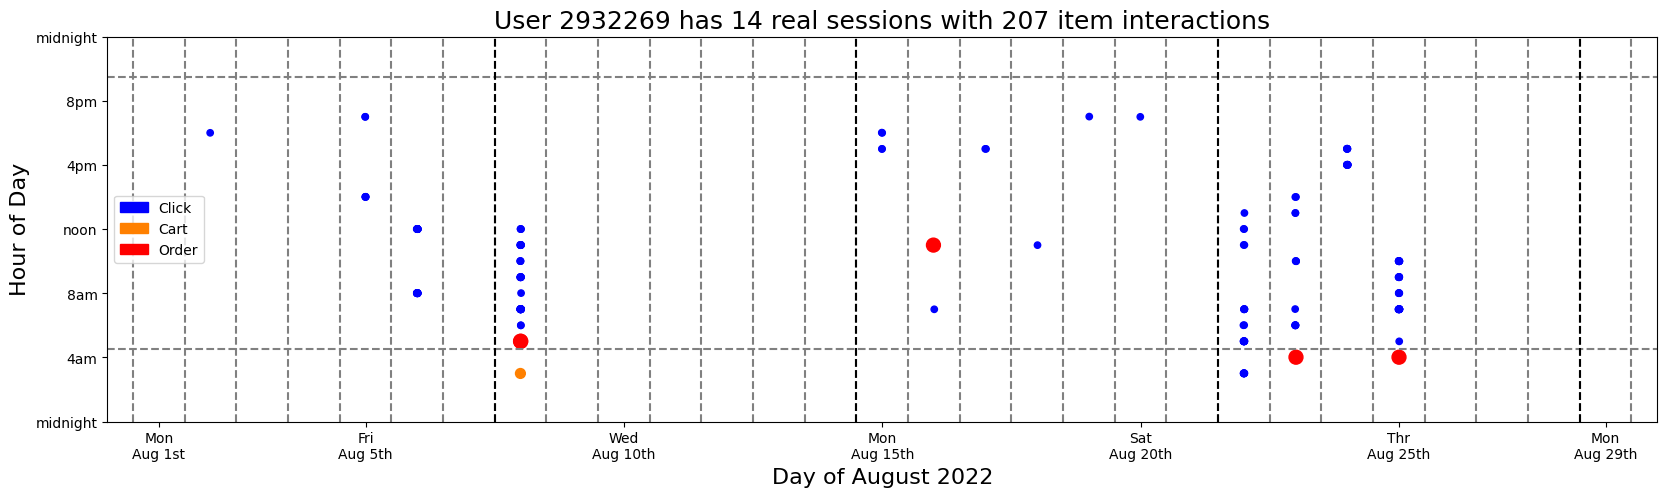

In [41]:
u = 2932269
tmp = train.loc[train.session == u].reset_index().to_pandas()
tmp = tmp.sort_values(['ts']).reset_index(drop=True)
tmp['d'] = tmp['subcount'].copy()

ss = tmp.d.max()+1
ii = len(tmp)
print(ss, ii)

plt.figure(figsize=(20,5))
for j in [0,1,2]:
    s = 21
    if j==1: s=50
    elif j==2: s=100
    tmp2 = tmp.loc[tmp['type']==j]
    xx = np.random.uniform(-0.01,0.01,len(tmp2))
    yy = np.random.uniform(-0.01,0.01,len(tmp2))
    plt.scatter(tmp2.day.values+xx, tmp2.hour.values+yy, s=s, c=colors[tmp2['type'].values])
plt.ylim((0,24))
plt.xlim((0,30))
c1 = mpatches.Patch(color=colors[0], label='Click')
c2 = mpatches.Patch(color=colors[1], label='Cart')
c3 = mpatches.Patch(color=colors[2], label='Order')
plt.plot([0,30],[5-0.5,5-0.5],'--',color='gray')
plt.plot([0,30],[21+0.5,21+0.5],'--',color='gray')
for k in range(0,30):
    plt.plot([k+0.5,k+0.5],[0,24],'--',color='gray')
for k in range(1,5):
    plt.plot([7*k+0.5,7*k+0.5],[0,24],'--',color='black')
plt.legend(handles=[c1,c2,c3])
plt.xlabel('Day of August 2022',size=16)
plt.xticks([1,5,10,15,20,25,29],['Mon\nAug 1st','Fri\nAug 5th','Wed\nAug 10th','Mon\nAug 15th','Sat\nAug 20th','Thr\nAug 25th','Mon\nAug 29th'])
plt.ylabel('Hour of Day',size=16)
plt.yticks([0,4,8,12,16,20,24],['midnight','4am','8am','noon','4pm','8pm','midnight'])
plt.title(f'User {u} has {ss} real sessions with {ii} item interactions',size=18)
plt.show()
print('\n\n')

In [42]:
#del train['hour'], train['day'], train['week'], train['subsession']
del train['subsession']
freemem(train)
gc.collect()
train.head()

,session,aid,ts,type,isvalid,fold,week,day,subcount,hour
0,172,1293949,501169,0,0,0,0,5,8,19
1,172,1372006,501178,0,0,0,0,5,8,19
2,172,1293949,501192,0,0,0,0,5,8,19
3,172,1293949,501208,0,0,0,0,5,8,19
4,172,1378087,501217,0,0,0,0,5,8,19


In [43]:
train.groupby(['fold', 'isvalid'])['aid'].count().reset_index().sort_values(['fold', 'isvalid'])

,fold,isvalid,aid
8,-1,-1,7025382
16,0,0,203531486
18,1,1,790168
19,1,2,775319
0,2,1,783103
11,2,2,770535
17,3,1,783954
10,3,2,770259
6,4,1,780292
14,4,2,769015


In [44]:
train.head()

,session,aid,ts,type,isvalid,fold,week,day,subcount,hour
0,172,1293949,501169,0,0,0,0,5,8,19
1,172,1372006,501178,0,0,0,0,5,8,19
2,172,1293949,501192,0,0,0,0,5,8,19
3,172,1293949,501208,0,0,0,0,5,8,19
4,172,1378087,501217,0,0,0,0,5,8,19


In [42]:
!rm -r fold
!mkdir fold

In [43]:
tmp = train.loc[train.fold < 0].reset_index(drop=True)
for n, s in enumerate(range(0, tmp.shape[0], 2000000)):
    e = s+2000000
    if e > tmp.shape[0]: e = tmp.shape[0]
    tmp2 = tmp.iloc[s:e].copy().reset_index(drop=True)
    tmp2.to_parquet(f'fold/test-split{n}.parquet')
    del tmp2
del tmp
gc.collect()

90

In [44]:
tmp = train.loc[train.isvalid >= 1].reset_index(drop=True)
for n, s in enumerate(range(0, tmp.shape[0], 2000000)):
    e = s+2000000
    if e > tmp.shape[0]: e = tmp.shape[0]
    tmp2 = tmp.iloc[s:e].copy().reset_index(drop=True)
    tmp2.to_parquet(f'fold/valid-split{n}.parquet')
    del tmp2
del tmp
gc.collect()

60

In [45]:
gc.collect()
for n, s in enumerate(range(0, train.shape[0], 2000000)):
    e = s+2000000
    if e > train.shape[0]: e = train.shape[0]
    tmp2 = train.iloc[s:e].copy().reset_index(drop=True)
    tmp2 = tmp2.loc[tmp2.fold == 0]
    if tmp2.shape[0]>0:
        tmp2.to_parquet(f'fold/train-split{n}.parquet')
    del tmp2
gc.collect()

584

In [46]:
# tmp = train.loc[train.isvalid == 2].reset_index(drop=True)
# for n, s in enumerate(range(0, tmp.shape[0], 2000000)):
#     e = s+2000000
#     if e > tmp.shape[0]: e = tmp.shape[0]
#     tmp2 = tmp.iloc[s:e].copy().reset_index(drop=True)
#     tmp2.to_parquet(f'fold/valid-extra{n}.parquet')
#     del tmp2
# del tmp
# gc.collect()

# Full processing Done!

In [46]:
from glob import glob
trainfiles = glob('fold/train-split*.parquet')
validfiles = glob('fold/valid-split*.parquet')
validfiles2 = glob('fold/valid-extra*.parquet')
testfiles = glob('fold/test-split*.parquet')
gc.collect()
len(trainfiles), len(validfiles), len(validfiles2), len(testfiles)

(102, 8, 0, 4)

In [48]:
train = pd.read_parquet(trainfiles)
valid = pd.read_parquet(validfiles)
test = pd.read_parquet(testfiles)

train.shape, valid.shape, test.shape
#((203531486, 10), (15524067, 10), (7025382, 10))

((203531486, 10), (15524067, 10), (7025382, 10))

In [49]:
train = pd.read_parquet(trainfiles+validfiles+validfiles2+testfiles)
train.shape
#(223667178, 10)

(226080935, 10)

In [50]:
sessions = train.loc[train.isvalid>0].copy().reset_index(drop=True)
sessions

,session,aid,ts,type,isvalid,fold,week,day,subcount,hour
0,11754259,1145773,2020906,0,1,10,3,23,2,9
1,11754259,1145773,2021068,1,1,10,3,23,2,9
2,11751603,1577260,2019747,0,1,4,3,23,0,9
3,11751603,1535386,2019919,0,2,4,3,23,0,9
4,11751604,594841,2019748,0,1,5,3,23,2,9
...,...,...,...,...,...,...,...,...,...,...
15524062,11306621,566951,1875508,0,2,2,3,21,0,16
15524063,11306622,1601791,1871351,0,1,3,3,21,0,15
15524064,11306617,868822,1871389,0,1,8,3,21,0,15
15524065,11306617,819288,1871416,0,1,8,3,21,0,15


In [51]:
mapfold = sessions.drop_duplicates(['session', 'fold']).set_index('session').to_dict()['fold']; gc.collect()

79

In [70]:
labels = pd.read_parquet('../input/radek/valid_labels.parquet')
labels = labels.explode('ground_truth')
labels

,session,type,ground_truth
0,11098528,clicks,1679529
1,11098528,carts,1199737
2,11098528,orders,990658
2,11098528,orders,950341
2,11098528,orders,1462506
...,...,...,...
2212687,12899774,clicks,1399483
2212688,12899775,clicks,1760714
2212689,12899776,clicks,1737908
2212690,12899777,clicks,384045


In [71]:
labels = labels.loc[labels.session.isin(sessions.session)].reset_index(drop=True)
labels['fold'] = labels['session'].map(mapfold)
labels = labels.rename(columns={'ground_truth': 'aid'})
labels.to_parquet('fold/labels.parquet')
labels

,session,type,aid,fold
0,11098528,clicks,1679529,9
1,11098528,carts,1199737,9
2,11098528,orders,990658,9
3,11098528,orders,950341,9
4,11098528,orders,1462506,9
...,...,...,...,...
2650367,12899774,clicks,1399483,5
2650368,12899775,clicks,1760714,6
2650369,12899776,clicks,1737908,7
2650370,12899777,clicks,384045,8


In [72]:
labels = labels.loc[labels['type']=='clicks'].reset_index(drop=True)
labels

,session,type,aid,fold
0,11098528,clicks,1679529,9
1,11098529,clicks,1105029,10
2,11098532,clicks,1596491,3
3,11098533,clicks,1417450,4
4,11098534,clicks,908024,5
...,...,...,...,...
1755529,12899774,clicks,1399483,5
1755530,12899775,clicks,1760714,6
1755531,12899776,clicks,1737908,7
1755532,12899777,clicks,384045,8


In [73]:
tmp = train.loc[(train.session == 12899775)].sort_values('ts')
tmp

,session,aid,ts,type,isvalid,fold,week,day,subcount,hour
NaN,12899775,1743151,2404891,0,1,6,3,27,0,20
NaN,12899775,1760714,2404911,0,2,6,3,27,0,20


In [47]:
for mode in ['clicks','carts','orders']:
    labels = cudf.read_parquet('fold/labels.parquet')
    labels = labels.loc[labels.type == mode].reset_index(drop=True)
    del labels['type']
    labels = labels.groupby('session')['aid'].agg(list).reset_index()
    labels.to_parquet(f'labels-{mode}.parquet')

In [63]:
tgt = pd.read_parquet(f'labels-clicks.parquet')
tgt['aid'] = tgt['aid'].apply(lambda x: x[0])
tgt

,session,aid
0,11098528,1679529
1,11098529,1105029
2,11098532,1596491
3,11098533,1417450
4,11098534,908024
...,...,...
1755529,12899774,1399483
1755530,12899775,1760714
1755531,12899776,1737908
1755532,12899777,384045


In [64]:
from glob import glob
validfiles = glob('fold/valid-split*.parquet')
valid = pd.read_parquet(validfiles)
valid.head()

,session,aid,ts,type,isvalid,fold,week,day,subcount,hour
0,11754259,1145773,2020906,0,1,10,3,23,2,9
1,11754259,1145773,2021068,1,1,10,3,23,2,9
2,11751603,1577260,2019747,0,1,4,3,23,0,9
3,11751603,1535386,2019919,0,2,4,3,23,0,9
4,11751604,594841,2019748,0,1,5,3,23,2,9


In [65]:
ses = list(valid.loc[valid.isvalid==1, 'session'].unique())
len(ses)

1801251

In [66]:
valid['hit'] = valid['session'].isin(tgt.session)
valid.loc[valid['hit']==False]

,session,aid,ts,type,isvalid,fold,week,day,subcount,hour,hit
34,11754419,52009,2031250,1,1,10,3,23,1,12,False
35,11754419,1174122,2209731,0,1,10,3,25,0,13,False
36,11754419,1174122,2209738,1,1,10,3,25,0,13,False
37,11754419,898639,2209743,0,1,10,3,25,0,13,False
38,11754419,898639,2209744,1,1,10,3,25,0,13,False
...,...,...,...,...,...,...,...,...,...,...,...
15523984,11308503,1037631,1871862,0,1,4,3,21,0,15,False
15523985,11308503,1037631,1871878,1,1,4,3,21,0,15,False
15523986,11308503,752439,1871899,0,1,4,3,21,0,15,False
15523987,11308503,1420264,1872329,0,1,4,3,21,0,16,False


In [57]:
valid = cudf.read_parquet('../input/radek/valid.parquet')
label = cudf.read_parquet('../input/radek/valid_labels.parquet')
valid.session.nunique()

1801251

In [58]:
label.session.nunique()

1801251

In [60]:
label = label.loc[label.type == 'clicks']
label

,session,type,ground_truth
0,11098528,clicks,[1679529]
3,11098529,clicks,[1105029]
6,11098532,clicks,[1596491]
7,11098533,clicks,[1417450]
10,11098534,clicks,[908024]
...,...,...,...
2212687,12899774,clicks,[1399483]
2212688,12899775,clicks,[1760714]
2212689,12899776,clicks,[1737908]
2212690,12899777,clicks,[384045]
